## Import Libraries


In [5]:
import torch
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import warnings

warnings.filterwarnings("ignore")

## Load Data


In [20]:
BASE_DIRECTORY = "dataset"

df = pd.read_csv(BASE_DIRECTORY + "/captions.txt")
df["path"] = df["image"].apply(lambda x: BASE_DIRECTORY + "/Image/" + x)
df = df.rename(columns={"image": "id"})
df["id"] = df["id"].str.replace(".jpg", "")
df.head()

,id,caption,path
0,1000268201_693b08cb0e,A child in a pink dress is climbing up a set o...,dataset/Image/1000268201_693b08cb0e.jpg
1,1000268201_693b08cb0e,A girl going into a wooden building .,dataset/Image/1000268201_693b08cb0e.jpg
2,1000268201_693b08cb0e,A little girl climbing into a wooden playhouse .,dataset/Image/1000268201_693b08cb0e.jpg
3,1000268201_693b08cb0e,A little girl climbing the stairs to her playh...,dataset/Image/1000268201_693b08cb0e.jpg
4,1000268201_693b08cb0e,A little girl in a pink dress going into a woo...,dataset/Image/1000268201_693b08cb0e.jpg


In [7]:
print("Dataframe shape:", df.shape)
unique_id_count = df["id"].nunique()
print("Number of samples", unique_id_count)

Dataframe shape: (40455, 3)
Number of samples 8091


### Build Dictionary


In [8]:
data = {}

for i in range(0, len(df), 5):
    id = df["id"][i]
    captions = [df["caption"][j] for j in range(i, i + 5)]
    path = df["path"][i]
    data[id] = {"captions": captions, "path": path}
    
keys = list(data.keys())

key = keys[0]
value = data[key]

print(f"Key: {key}")
value

Key: 1000268201_693b08cb0e


{'captions': ['A child in a pink dress is climbing up a set of stairs in an entry way .',
  'A girl going into a wooden building .',
  'A little girl climbing into a wooden playhouse .',
  'A little girl climbing the stairs to her playhouse .',
  'A little girl in a pink dress going into a wooden cabin .'],
 'path': 'dataset/Images/1000268201_693b08cb0e.jpg'}

### Split the dictionary into train, test, and validation sets


In [9]:
# Select keys for the training set
train_keys = keys[:6000]

# Select keys for the validation set
val_keys = keys[6000:7000]

# The remaining keys are for the testing set
test_keys = keys[7000:]

# Create the training, validation, and testing sets
train_data = {key: data[key] for key in train_keys}
val_data = {key: data[key] for key in val_keys}
test_data = {key: data[key] for key in test_keys}

train_keys = list(train_data.keys())
val_keys = list(val_data.keys())
test_keys = list(test_data.keys())

print("Training set size:", len(train_data))
print("Validation set size:", len(val_data))
print("Testing set size:", len(test_data))

Training set size: 6000
Validation set size: 1000
Testing set size: 1091


## Read & Show Image Data


In [10]:
def read_image(path):
    return Image.open(path)


def show_image(image):
    plt.imshow(image)
    plt.axis("off")
    plt.show()


def read_from_tensor(tensor):
    img_numpy = tensor.permute(1, 2, 0).numpy()
    img_numpy = np.clip(img_numpy, 0, 1)
    plt.imshow(img_numpy)
    plt.axis("off")
    plt.show()

### Example of an image with captions


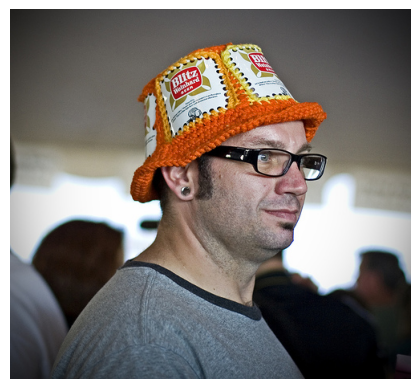

A man in an orange hat starring at something .
A man wears an orange hat and glasses .
A man with gauges and glasses is wearing a Blitz hat .
A man with glasses is wearing a beer can crocheted hat .
The man with pierced ears is wearing glasses and an orange hat .


In [11]:
show_image(read_image(train_data[train_keys[4]]["path"]))
for i in range(5):
    print(train_data[train_keys[4]]["captions"][i])

## Preprocess the Data


### Transformations

In [21]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0), ratio=(0.95, 1.05), antialias=True),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)


### Apply the transformations to train, test, and validation sets

In [22]:
train_tensors = [train_transform(read_image(train_data[key]["path"])) for key in train_keys]
train_tensors = torch.stack(train_tensors)

val_tensors = [val_test_transform(read_image(val_data[key]["path"])) for key in val_keys]
val_tensors = torch.stack(val_tensors)

test_tensors = [val_test_transform(read_image(test_data[key]["path"])) for key in test_keys]
test_tensors = torch.stack(test_tensors)


print("Training tensor shape:", train_tensors.shape)
print("Validation tensor shape:", val_tensors.shape)
print("Testing tensor shape:", test_tensors.shape)

Training tensor shape: torch.Size([6000, 3, 224, 224])
Validation tensor shape: torch.Size([1000, 3, 224, 224])
Testing tensor shape: torch.Size([1091, 3, 224, 224])


### Map the captions to the image from tensors

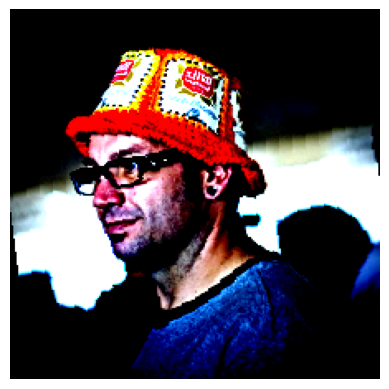

A man in an orange hat starring at something .
A man wears an orange hat and glasses .
A man with gauges and glasses is wearing a Blitz hat .
A man with glasses is wearing a beer can crocheted hat .
The man with pierced ears is wearing glasses and an orange hat .


In [23]:
read_from_tensor(train_tensors[4])
for i in range(5):
    print(train_data[train_keys[4]]["captions"][i])